In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
class CatDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = glob.glob(os.path.join(image_dir, '**/*.jpg'), recursive=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        
        annotation_path = img_path + '.cat'
        with open(annotation_path, 'r') as f:
            annotations = list(map(int, f.readline().split()[1:]))
        
        original_width, original_height = img.size
        target_width, target_height = 64, 64
        
        # Scale annotations
        annotations[0::2] = [x * (target_width / original_width) for x in annotations[0::2]]
        annotations[1::2] = [y * (target_height / original_height) for y in annotations[1::2]]
        
        annotations = torch.tensor(annotations)
        
        if self.transform:
            img = self.transform(img)
        
        return img, annotations

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [10]:
image_dir = "C:/Users/osyed/OneDrive/Desktop/AIML Assessment project"
dataset = CatDataset(image_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

Sample Image Dimensions (HxW): 64 64
Sample Annotations: tensor([29.8667, 20.4800, 40.7893, 20.7360, 33.9627, 25.4720, 25.4293, 15.4880,
        23.3813,  9.9840, 28.3307, 11.9040, 47.9573, 12.9280, 53.2480, 12.2880,
        50.5173, 17.0240])


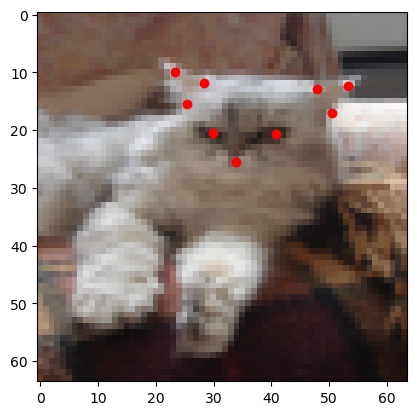

In [11]:
# Visualize a sample image and its annotations
sample_img, sample_annotations = dataset[0]

print("Sample Image Dimensions (HxW):", sample_img.shape[1], sample_img.shape[2])
print("Sample Annotations:", sample_annotations)

plt.imshow(sample_img.permute(1, 2, 0))
plt.scatter(sample_annotations[0::2], sample_annotations[1::2], c='red')
plt.show()

In [12]:
import torch.nn as nn

In [13]:
class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [14]:
model = DiffusionModel()

In [15]:
import torch.optim as optim

In [16]:
def train_model(model, dataloader, num_epochs=25):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, _ in dataloader:
            images = images.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(dataloader)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
    return train_losses, val_losses

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses, val_losses = train_model(model, data_loader, num_epochs=50)

Epoch 1/50, Loss: 0.0099
Epoch 2/50, Loss: 0.0026
Epoch 3/50, Loss: 0.0020
Epoch 4/50, Loss: 0.0016
Epoch 5/50, Loss: 0.0013
Epoch 6/50, Loss: 0.0012
Epoch 7/50, Loss: 0.0010
Epoch 8/50, Loss: 0.0009
Epoch 9/50, Loss: 0.0008
Epoch 10/50, Loss: 0.0008
Epoch 11/50, Loss: 0.0007
Epoch 12/50, Loss: 0.0007
Epoch 13/50, Loss: 0.0006
Epoch 14/50, Loss: 0.0006
Epoch 15/50, Loss: 0.0006
Epoch 16/50, Loss: 0.0005
Epoch 17/50, Loss: 0.0005
Epoch 18/50, Loss: 0.0005
Epoch 19/50, Loss: 0.0005
Epoch 20/50, Loss: 0.0004
Epoch 21/50, Loss: 0.0004
Epoch 22/50, Loss: 0.0004
Epoch 23/50, Loss: 0.0004
Epoch 24/50, Loss: 0.0004
Epoch 25/50, Loss: 0.0004
Epoch 26/50, Loss: 0.0003
Epoch 27/50, Loss: 0.0003
Epoch 28/50, Loss: 0.0003
Epoch 29/50, Loss: 0.0003
Epoch 30/50, Loss: 0.0003
Epoch 31/50, Loss: 0.0003
Epoch 32/50, Loss: 0.0003
Epoch 33/50, Loss: 0.0003
Epoch 34/50, Loss: 0.0003
Epoch 35/50, Loss: 0.0003
Epoch 36/50, Loss: 0.0003
Epoch 37/50, Loss: 0.0003
Epoch 38/50, Loss: 0.0003
Epoch 39/50, Loss: 0.

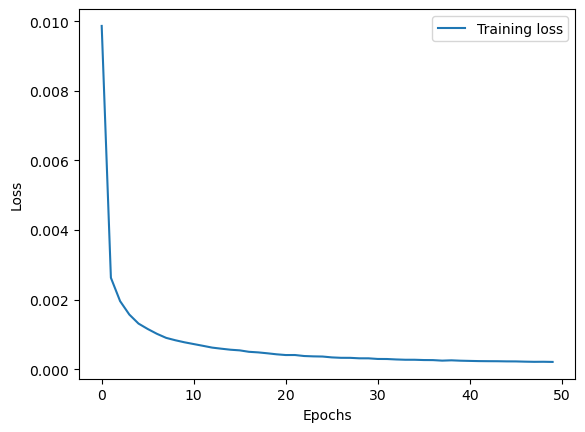

In [18]:
# Plotting the loss graph
plt.plot(train_losses, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


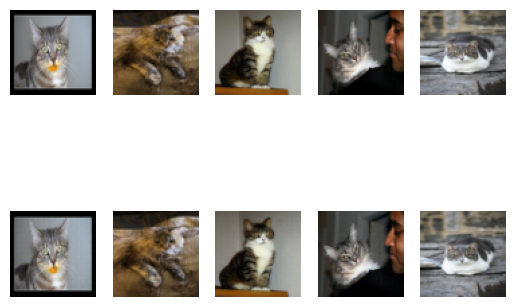

In [19]:
def visualize_generated_images(model, dataloader, num_images=5):
    model.eval()
    images, _ = next(iter(dataloader))
    images = images[:num_images]
    
    with torch.no_grad():
        generated_images = model(images.to(device)).cpu()
    
    for i in range(num_images):
        plt.subplot(2, num_images, i+1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.axis('off')
        
        plt.subplot(2, num_images, i+1+num_images)
        plt.imshow(generated_images[i].permute(1, 2, 0))
        plt.axis('off')
    plt.show()

visualize_generated_images(model, data_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


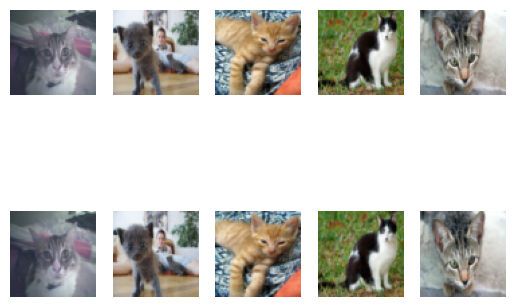

In [26]:
visualize_generated_images(model, data_loader)

In [21]:
import torch

# Define the function to save the model
def save_model(model, model_name, path='./'):
    torch.save(model.state_dict(), os.path.join(path, f"{model_name}.pth"))



In [22]:
# Save the trained model with a custom name
model_name = "DiffusionModel"
save_model(model, model_name)

In [23]:
# Define the function to load the model
def load_model(model, model_name, path='./'):
    model.load_state_dict(torch.load(os.path.join(path, f"{model_name}.pth")))
    return model



In [24]:
# Create a new model instance and load the saved state dictionary
loaded_model = DiffusionModel()
loaded_model = load_model(loaded_model, model_name)
loaded_model.to(device)

DiffusionModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import spectral_norm

In [56]:
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.model(z)

In [57]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x).view(-1, 1)

In [60]:
from tqdm import tqdm

def train_gan(generator, discriminator, dataloader, num_epochs=10, latent_dim=128):
    criterion = nn.BCELoss()
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    scheduler_g = optim.lr_scheduler.StepLR(g_optimizer, step_size=30, gamma=0.1)
    scheduler_d = optim.lr_scheduler.StepLR(d_optimizer, step_size=30, gamma=0.1)
    
    for epoch in range(num_epochs):
        d_losses = []
        g_losses = []
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for real_images, _ in progress_bar:
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            # Train Discriminator
            d_optimizer.zero_grad()
            
            real_labels = torch.ones(batch_size, 1).to(device) * 0.9  # Label smoothing
            real_output = discriminator(real_images)
            d_loss_real = criterion(real_output, real_labels)
            
            z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
            fake_images = generator(z)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            fake_output = discriminator(fake_images.detach())
            d_loss_fake = criterion(fake_output, fake_labels)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()
            
            # Train Generator
            g_optimizer.zero_grad()
            
            z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
            fake_images = generator(z)
            output = discriminator(fake_images)
            g_loss = criterion(output, real_labels)
            
            g_loss.backward()
            g_optimizer.step()
            
            # Record losses
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            
            # Update progress bar
            progress_bar.set_postfix({'D Loss': f"{d_loss.item():.4f}", 'G Loss': f"{g_loss.item():.4f}"})
        
        scheduler_g.step()
        scheduler_d.step()
        
        # Print epoch summary
        print(f"Epoch [{epoch+1}/{num_epochs}], Avg D Loss: {sum(d_losses)/len(d_losses):.4f}, Avg G Loss: {sum(g_losses)/len(g_losses):.4f}")
        
        if (epoch + 1) % 10 == 0:
            generate_cat_images(generator, latent_dim)

Epoch 1/10: 100%|██████████████████████████████████████| 625/625 [19:38<00:00,  1.89s/it, D Loss=1.3793, G Loss=0.7916]


Epoch [1/10], Avg D Loss: 1.1646, Avg G Loss: 1.3876


Epoch 2/10: 100%|██████████████████████████████████████| 625/625 [13:02<00:00,  1.25s/it, D Loss=1.3167, G Loss=0.7677]


Epoch [2/10], Avg D Loss: 1.2916, Avg G Loss: 0.9804


Epoch 3/10: 100%|██████████████████████████████████████| 625/625 [22:17<00:00,  2.14s/it, D Loss=1.1482, G Loss=1.1328]


Epoch [3/10], Avg D Loss: 1.2767, Avg G Loss: 0.9911


Epoch 4/10: 100%|██████████████████████████████████████| 625/625 [24:20<00:00,  2.34s/it, D Loss=1.3935, G Loss=0.8699]


Epoch [4/10], Avg D Loss: 1.3055, Avg G Loss: 0.9483


Epoch 5/10: 100%|██████████████████████████████████████| 625/625 [22:37<00:00,  2.17s/it, D Loss=1.2204, G Loss=0.9400]


Epoch [5/10], Avg D Loss: 1.2748, Avg G Loss: 1.0124


Epoch 6/10: 100%|██████████████████████████████████████| 625/625 [15:17<00:00,  1.47s/it, D Loss=1.0750, G Loss=1.2220]


Epoch [6/10], Avg D Loss: 1.2462, Avg G Loss: 1.0530


Epoch 7/10: 100%|██████████████████████████████████████| 625/625 [14:44<00:00,  1.42s/it, D Loss=1.0790, G Loss=1.1025]


Epoch [7/10], Avg D Loss: 1.2057, Avg G Loss: 1.1526


Epoch 8/10: 100%|██████████████████████████████████████| 625/625 [14:26<00:00,  1.39s/it, D Loss=1.0041, G Loss=1.3302]


Epoch [8/10], Avg D Loss: 1.1750, Avg G Loss: 1.1974


Epoch 9/10: 100%|██████████████████████████████████████| 625/625 [15:54<00:00,  1.53s/it, D Loss=1.0195, G Loss=1.1000]


Epoch [9/10], Avg D Loss: 1.1589, Avg G Loss: 1.2008


Epoch 10/10: 100%|█████████████████████████████████████| 625/625 [16:32<00:00,  1.59s/it, D Loss=1.2480, G Loss=1.0964]


Epoch [10/10], Avg D Loss: 1.1616, Avg G Loss: 1.1360


C:\Users\osyed\AppData\Local\Temp\ipykernel_17860\640614588.py:18: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


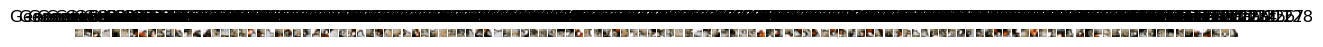

In [61]:
# Initialize and train the GAN
latent_dim = 128
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
train_gan(generator, discriminator, data_loader, num_epochs=10, latent_dim=latent_dim)

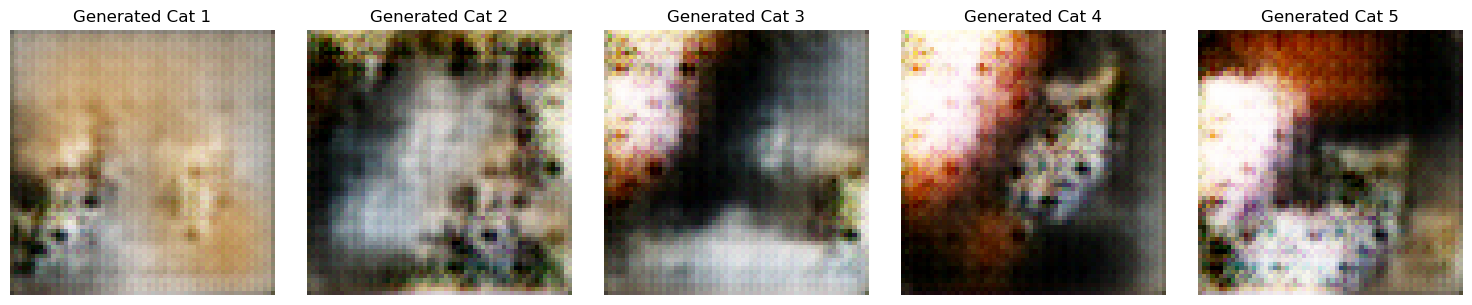

In [65]:
def generate_cat_images(model, latent_dim, num_images=5):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim, 1, 1).to(device)
        generated_images = model(z)
        
        fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
        for i, img in enumerate(generated_images):
            ax = axes[i]
            ax.imshow(img.cpu().permute(1, 2, 0).clip(0, 1))
            ax.axis('off')
            ax.set_title(f"Generated Cat {i+1}")
        
        plt.tight_layout()
        plt.show()

# Generate and visualize new cat images
generate_cat_images(generator, latent_dim)

In [63]:
# Save the trained model with a custom name
model_name = "DiffusionModelUpdated"
save_model(model, model_name)